### Importing dependencies

In [1]:
import keras
from keras import Sequential
from keras import layers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import Model
import matplotlib.pyplot as plt
import os, shutil
from livelossplot import PlotLossesKeras
import numpy as np

keras.__version__

Using TensorFlow backend.


'2.2.0'

In [2]:
!pwd
!which python

/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50
/usr/bin/python


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0' 

In [4]:
batch_size = 128
img_size = 224
epochs = 3

### Prepare data directories

Let's prepare directories for our datacut.
We'll use a fraction of the full dataset. We'll keep our data organized into train, test, validation folders; each with separate dogs and cats subfolders.


In [5]:
# original_dataset_dir = "/Users/raf/Documents/Coding/2018/fastai/fastai/courses/dl1/data/train"
original_dataset_dir = '/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data'

# The directory where we will store our smaller dataset
# base_dir = "/Users/raf/Documents/Coding/2018/codilime/blogpost2/resnet-finetuning-in-keras-and-pytorch/data/data_sample"
base_dir = '/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data_small'

In [6]:
print('Total images:', len(os.listdir(original_dataset_dir)))

Total images: 25000


In [7]:
# We want to keep our data organized into train, test, validation folders, each with separate dogs and cats subfolders
categories = ['cats', 'dogs']
str_train_val_test = ['train','validation', 'test']
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
    print('Created directory: ', base_dir)
        
for dir_type in str_train_val_test:
    train_test_val_dir = os.path.join(base_dir, dir_type)

    if not os.path.exists(train_test_val_dir):
        os.mkdir(train_test_val_dir)

    for category in categories:
        dir_type_category = os.path.join(train_test_val_dir, category)
        
        if not os.path.exists(dir_type_category):
            os.mkdir(dir_type_category)
            print('Created directory: ', dir_type_category)

### Organise train/validation/test data

In [8]:
directories_dict = {} # To store directory paths for data subsets.

for range_, dir_type in zip([range(1000), range(1000, 1500), range(1500, 2000)], str_train_val_test):
    for _, category in enumerate(categories):
        fnames = [category[:-1] + "." + str(i) + "." + "jpg" for i in range_]
        

        if _ == 0:
                directories_dict[str(dir_type)+ "_dir"] = os.path.join(base_dir, 
                                                                       dir_type, 
                                                                       )                          
        for _, fname in enumerate(fnames):
            
            if _ == 0:
                directories_dict[str(dir_type)+ "_" +str(category) + "_dir"] =  os.path.join(base_dir, 
                                                                                         dir_type, 
                                                                                         category)  
                
                
# #            If you don't want files to be copied, comment out from here 
#             source = os.path.join(original_dataset_dir, fname)
#             destination = os.path.join(base_dir, dir_type, category, fname)
#             shutil.copyfile(source, destination)         
# #             to here

In [9]:
directories_dict

{'test_cats_dir': '/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data_small/test/cats',
 'test_dir': '/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data_small/test',
 'test_dogs_dir': '/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data_small/test/dogs',
 'train_cats_dir': '/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data_small/train/cats',
 'train_dir': '/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data_small/train',
 'train_dogs_dir': '/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data_small/train/dogs',
 'validation_cats_dir': '/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data_small/validation/cats',
 'validation_dir': '/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data_small/validation',
 'validation_dogs_dir': '/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data_small/validation/dogs'}

In [10]:
print('Total training cat images:', len(os.listdir(directories_dict['train_cats_dir'])))
print('Total training dog images:', len(os.listdir(directories_dict['train_cats_dir'])))
print("-"*32)
print('Total test cat images:', len(os.listdir(directories_dict['test_cats_dir'])))
print('Total test dog images:', len(os.listdir(directories_dict['test_dogs_dir'])))
print("-"*32)
print('Total validation cat images:', len(os.listdir(directories_dict['validation_cats_dir'])))
print('Total validation dog images:', len(os.listdir(directories_dict['validation_dogs_dir'])))


Total training cat images: 1000
Total training dog images: 1000
--------------------------------
Total test cat images: 500
Total test dog images: 500
--------------------------------
Total validation cat images: 500
Total validation dog images: 500


### Create Keras data generators 

In [11]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    directories_dict['train_dir'],
    batch_size=batch_size,
    class_mode='binary',
    target_size=(224,224))

validation_generator = validation_datagen.flow_from_directory(
    directories_dict['validation_dir'],
    shuffle=False,
    class_mode='binary',
    target_size=(224,224))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Import pre-trained ResNet 

Time to load the pre-trained ResNet model. We'll freeze all layers, so there's no backpropagation of gradients through the ResNet50 layers (this saves us A LOT of time and resources)

In [12]:
keras.backend.set_learning_phase(0) # see https://github.com/keras-team/keras/issues/9214  and https://github.com/keras-team/keras/pull/9965

conv_base = ResNet50(
    include_top=False,
    weights='imagenet')

# freeze layers in resnet50
for layer in conv_base.layers:
    layer.trainable = False

### Stack trainable, fully-connected (dense) layers on top of it

These are the layers, which will have randomly initiated weights: these are the ones we'll actually train.

In [13]:
model = conv_base.output
keras.backend.set_learning_phase(1)
model = layers.GlobalAveragePooling2D()(model)

# add fc layers
model = layers.Dense(128)(model) 
predictions = layers.Dense(1, activation='sigmoid')(model)

In [14]:
model = Model(conv_base.input, predictions)

In [15]:
# [conv_base.layers[i].trainable for i in range(len(conv_base.layers))]

In [16]:
optimizer = keras.optimizers.rmsprop()

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
model_checkpoint_dir = "./output"

if not os.path.exists(model_checkpoint_dir):
    os.mkdir(model_checkpoint_dir)
    print('Created directory: ', model_checkpoint_dir)

model_checkpoint_dir = model_checkpoint_dir + "/best_model.hdf5"


Keras API allows us to easily save the model architecture at the stage it reaches the best validation accuracy (or any metric we want to optimize for). The saving is done through ModelCheckpoint callback.

In [18]:
checkpoint_save_best = ModelCheckpoint(model_checkpoint_dir, monitor='val_acc',
verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)

In [19]:
len(model.trainable_weights)

4

In [20]:
%%time

history = model.fit_generator(generator=train_generator,
                    epochs=epochs,
                    validation_data=validation_generator, 
                    steps_per_epoch = train_generator.n // batch_size,
                    validation_steps = validation_generator.n // batch_size,
                    initial_epoch=0,
                    callbacks=[checkpoint_save_best])    

Epoch 1/3
15/15 [==============================] - 26s 2s/step - loss: 0.7234 - acc: 0.8785 - val_loss: 0.0787 - val_acc: 0.9866

Epoch 00001: val_acc improved from -inf to 0.98661, saving model to ./output/best_model.hdf5
Epoch 2/3
15/15 [==============================] - 24s 2s/step - loss: 0.1562 - acc: 0.9602 - val_loss: 1.3401 - val_acc: 0.7321

Epoch 00002: val_acc did not improve from 0.98661
Epoch 3/3
15/15 [==============================] - 25s 2s/step - loss: 0.1326 - acc: 0.9667 - val_loss: 0.1765 - val_acc: 0.9732

Epoch 00003: val_acc did not improve from 0.98661
CPU times: user 1min 25s, sys: 4.82 s, total: 1min 30s
Wall time: 1min 19s


### Loading model and evaluation 

In [21]:
keras.backend.clear_session()

In [22]:
loaded_model = load_model(model_checkpoint_dir, compile=False) #compile causes issues if not turned off - we are not training the model so we don't need to compile the model #the workaround to this user warning error might be to set all weights to not-trainable explicitly (in a loop) https://stackoverflow.com/questions/49195189/error-loading-the-saved-optimizer-keras-python-raspberry
print("Model loaded successfully!")

Model loaded successfully!


In [23]:
test_cat = "/mnt/ml-team/homes/rafal.jakubanis/blogpost2-resnet50/data_small/test/cats/cat.1505.jpg"

In [24]:
img = image.load_img(test_cat, target_size=(img_size, img_size))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
preds = loaded_model.predict(x)
preds
# pred_class = loaded_model.predict_classes(x)
# pred_class = loaded_model.probas_to_classes(x)

if preds[0][0] < 0.5:
    print("IT'S A CAT! ({:.2})".format(preds[0][0]))
else:
    print("IT'S A DOG! ({:.2})".format(preds[0][0]))

IT'S A CAT! (4.5e-09)


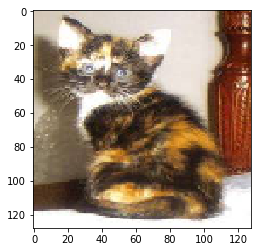

In [25]:
img = img.resize((128,128))
plt.imshow(img)
plt.show()